# SQL-based database

Defines an sqlite database, built from the json-based data dumps provided at 'https://github.com/adactio/TheSession-data'.

Tables are included for:

- Users
- Tunes
- Settings
- Aliases
- Recordings
- Recorded Tunes
- Events
- Sessions
- Sets of Tunes

Fields are added to the database from additional scraped directly from thesession.org, using the sites api, and from information consolidated by this codebase.

I plan to extend the database class with a variety of pythonic seach functions wrapping SQL queries for specific needs from other parts of the code.

In [6]:
from thesessionDB import thesessionDB


# db = thesessionDB(delete=True,download=True)

# db.defineTables()
# #db.populateTablesFromJSON(Ntest=1000)
# db.populateTablesFromJSON()



In [7]:
db = thesessionDB(delete=False,download=False)

#db.defineTables()
#db.populateTablesFromJSON(Ntest=1000)
#db.populateTablesFromJSON()

db.cur.execute('SELECT * FROM users LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Users:'
for x in q:
    print x

db.cur.execute('SELECT * FROM tunes LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Tunes:'
for x in q:
    print x

db.cur.execute('SELECT setting_id, tune_id, date, user FROM settings LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Settings:'
for x in q:
    print x

db.cur.execute('SELECT * FROM aliases LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Aliases:'
for x in q:
    print x

db.cur.execute('SELECT * FROM artists LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Artists:'
for x in q:
    print x

db.cur.execute('SELECT * FROM recordings LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Recordings:'
for x in q:
    print x

db.cur.execute('SELECT * FROM recorded_tunes LIMIT 5')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Recorded tunes:'
for x in q:
    print x

db.cur.execute('SELECT set_id,tune_position,num_tunes,tune_id,name FROM tune_sets LIMIT 10')
q = db.cur.fetchall()  # fetch all the results of the query

print ''
print 'Tune sets:'
for x in q:
    print x


Users:
(u'iliketurtles', None)
(u'danninagh', None)
(u'DonaldK', None)
(u'Charles Mackenzie', None)
(u'Micha\u0142 Zaj\u0105czkowski', None)

Tunes:
(u'11931', u"'G Iomain Nan Gamhna", u'slip jig', u'9/8', u'Gmajor')
(u'15326', u"'S Ann An \xccle", u'strathspey', u'4/4', u'Gmajor')
(u'14625', u"'S Daor An Tabac", u'reel', u'4/4', u'Bminor')
(u'13684', u'100 Watt Reels', u'reel', u'4/4', u'Ddorian')
(u'7078', u'10th Bat Crossing Rhine', u'jig', u'6/8', u'Amixolydian')

Settings:
(u'11931', u'11931', u'2012-05-17 07:49:26', u'iliketurtles')
(u'28560', u'15326', u'2016-03-31 15:34:45', u'danninagh')
(u'28582', u'15326', u'2016-04-03 09:15:08', u'DonaldK')
(u'26955', u'14625', u'2015-07-31 02:47:47', u'Charles Mackenzie')
(u'24291', u'13684', u'2014-06-14 13:57:17', u'Micha\u0142 Zaj\u0105czkowski')

Aliases:
(0, u'Cooleys', u"Cooley's", u'1')
(1, u'Joe Cooley', u"Cooley's", u'1')
(2, u"Joe Cooley's", u"Cooley's", u'1')
(3, u"Joe Cooley's Fancy", u"Cooley's", u'1')
(4, u'Joe Cooleys', u"C

In [1]:
from setBuilder import *

fragment = 'green'
unique_ids = tunesMatchFragment(fragment)
print 'There are ',len(unique_ids),' unique tunes with title containing ',"'"+fragment+"'" 


There are  80  unique tunes with title containing  'green'


In [4]:
# Find the distribution of tune types and modes for 'green' tunes

tid = unique_ids
q = tunesFromID(tid)

tune_types = [x['rhythm'] for x in q]
tune_modes = [x['mode'] for x in q]  # could define a tune array type to automatically handle this operation

In [7]:
q

[{'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u'Green Gowned Lass, The',
  'rhythm': u'reel',
  'tune_id': u'1015'},
 {'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u"Miss Forbes' Farewell To Banff",
  'rhythm': u'reel',
  'tune_id': u'10579'},
 {'meter': u'2/4',
  'mode': u'Gmajor',
  'name': u'Tralee Gaol',
  'rhythm': u'polka',
  'tune_id': u'1113'},
 {'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u'Over The Moor To Maggie',
  'rhythm': u'reel',
  'tune_id': u'115'},
 {'meter': u'6/8',
  'mode': u'Gmajor',
  'name': u'Lost And Found',
  'rhythm': u'jig',
  'tune_id': u'1160'},
 {'meter': u'3/4',
  'mode': u'Gmajor',
  'name': u'Cruaca Glas Na H\xc9ireann',
  'rhythm': u'waltz',
  'tune_id': u'11603'},
 {'meter': u'4/4',
  'mode': u'Dmajor',
  'name': u'Randy Wife Of Greenlaw, The',
  'rhythm': u'reel',
  'tune_id': u'11677'},
 {'meter': u'6/8',
  'mode': u'Dmajor',
  'name': u'New Rigged Ship, The',
  'rhythm': u'jig',
  'tune_id': u'1207'},
 {'meter': u'6/8',
  'mode': u'Gm

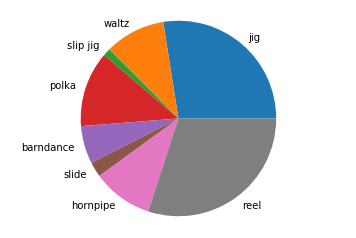

In [5]:
from matplotlib import pyplot as plt

%matplotlib inline

from collections import Counter
#import matplotlib.pyplot as plt


keys = Counter(tune_types).keys() # equals to list(set(words))
vals = Counter(tune_types).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal');
#plt.show();

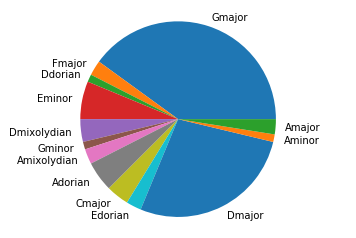

In [6]:
keys = Counter(tune_modes).keys() # equals to list(set(words))
vals = Counter(tune_modes).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
plt.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
plt.axis('equal');
#plt.show()

In [ ]:
# From here I am working to wrap common types of searches I need with the thesessionDB class.

In [26]:
class dict_output(object):
    def __init__(self, file_name, method):
        self.file_obj = open(file_name, method)
    def __enter__(self):
        return self.file_obj
    def __exit__(self, type, value, traceback):
        print("Exception has been handled")
        self.file_obj.close()
        return True

In [27]:
import sqlite3

def dict_factory(cursor, row):
    d = {}
    for idx, col in enumerate(cursor.description):
        d[col[0]] = row[idx]
    return d

class QueryFormat():
    '''
    Context manager to provide a sqlite cursor to a database, which will return query data in json format by default.
    '''
    
    def __init__(self,db,json=True):
        self.db = db
        self.json = json
        
    def __enter__(self,json=True):
        if json: # should figure out how to make this a wrapper
            db.conn.row_factory = dict_factory
            self.cursor = db.conn.cursor()
        else:
            self.cursor = db.cur
        
        return self.cursor
    
    def __exit__(self,*args):
        # reset format
        db.conn.row_factory = sqlite3.Row
               

def tunesFromAlias(fragment,json=True):
    
    # split the fragment on white space
    words = fragment.split()
    
    # join words in the query with wildcards to catch more with SQL LIKE
    querystr = '%' + '%'.join(words) + '%'
    
    # Find all matches for the fragment in the alias table
    #db.cur.execute("SELECT tune_id FROM aliases WHERE alias LIKE '%"+fragment+"%'")
    db.cur.execute("SELECT tune_id FROM aliases WHERE alias LIKE '"+querystr+"'")
    q = db.cur.fetchall()  # fetch all the results of the query

    tune_ids = [x[0] for x in q]

    # find all unique ids
    unique_ids = {x for x in tune_ids}
    
    query = "SELECT * FROM tunes WHERE tune_id IN ({0})".format(', '.join(x for x in unique_ids))

    # switch to json format for query and restore
    with QueryFormat(json) as c:
    
        c.execute(query)

        q2 = c.fetchall()
    
    return q2

tunesFromAlias('silver spear')

[{'meter': u'4/4',
  'mode': u'Dmajor',
  'name': u'Silver Spear, The',
  'rhythm': u'reel',
  'tune_id': u'182'},
 {'meter': u'4/4',
  'mode': u'Adorian',
  'name': u'New Mown Meadows, The',
  'rhythm': u'reel',
  'tune_id': u'2706'}]

In [28]:
def aliasesForTune(tune_id):
    '''
    Returns all known aliases of a given tune
    '''
    
    # Find all matches for the fragment in the alias table
    db.cur.execute("SELECT alias FROM aliases WHERE tune_id=?",[tune_id])
    q = db.cur.fetchall()
    
    return [x[0] for x in q]
aliasesForTune(u'1555')

[u"Dick Cosgrove's",
 u'Dick Cosgroves',
 u'Old Yellow Tinker, The',
 u"W'ere Be Da Fiddle?",
 u'Yellow Haired Tinker, The',
 u'Yellow Tinker, The']

In [43]:
def settingsOfTune(tune_id,json=True):
    '''
    Returns all known aliases of a given tune
    '''
    
    # switch to json format for query and restore
    with QueryFormat(json) as c:
    
        # Find all matches for the fragment in the alias table
        c.execute("SELECT * FROM settings WHERE tune_id=?",[tune_id])
        q = c.fetchall()
    
    return q
settingsOfTune(u'1555')[:5]

[{'abc': u'EAAG EGDG|EA~A2 fAeA|EAAG EDEF|1 G2BG =cGBG:|2 GABd dBGB||\r\nA2eA fAeA|fAeA dBGB|A2eA fAeA|d2BG DGBG|\r\nA2eA fAeA|fAeA dBGB|~e3f ~g3e|d2BG DGBG||',
  'bars': None,
  'date': u'2003-03-31 03:27:23',
  'meter': u'4/4',
  'mode': u'Amixolydian',
  'name': u'Drunken Tinker, The',
  'rhythm': u'reel',
  'setting_id': u'1555',
  'structure': None,
  'tune_id': u'1555',
  'user': u'Dr. Dow'},
 {'abc': u'EAAG EGDG|EA~A2 fAeA|EAAG EDEF|1 G2DG B,GDG:|2 GFGA BcdB||\r\nA2eA fAeA|fAeA dBGB|A2gA fAeA|d2BG EFGB|\r\nA2eA fAeA|fAeA dBGB|~e3f ~g3e|d2BG EFGB|',
  'bars': None,
  'date': u'2013-05-25 13:06:25',
  'meter': u'4/4',
  'mode': u'Amixolydian',
  'name': u'Drunken Tinker, The',
  'rhythm': u'reel',
  'setting_id': u'21585',
  'structure': None,
  'tune_id': u'1555',
  'user': u'Werner Zipperer'},
 {'abc': u'|:EAAG EGDG|EA A2 fAeA|EAAG EDEF| G2BG =cGBG| \r\nEAAG EGDG|EA A2 fAeA|EAAG EDEF|GABd dBGB||\r\n|:A2eA fAeA|fAeA dBGB|A2eA fAeA|d2BG DGBG|\r\nA2eA fAeA|fAeA dBGB|e3f g3e|d2BG DG

In [122]:
import sqlite3


def recordingsOfTune(tune_id,json=True):
    '''
    Returns all recordings of a given tune.
    '''
    
    # switch to json format for query and restore
    with QueryFormat(json) as c:
    
        c.execute("SELECT * FROM recorded_tunes WHERE tune_id=?",[tune_id])
        
        q = c.fetchall()

    return q

def userSetEntryWithTune(tune_id,field='tune_id',json=True):
    '''
    Returns all recordings of a given tune.
    
    Can match field other than 'tune_id' if 'field' is specified
    '''
    
    # switch to json format for query and restore
    with QueryFormat(json) as c:
        
        #db.cur.execute('SELECT set_id,tune_position,num_tunes,tune_id,name FROM tune_sets LIMIT 10')

        #c.execute("SELECT * FROM tune_sets WHERE tune_id=?",[tune_id])
        c.execute("SELECT * FROM tune_sets WHERE "+field+"=?",[tune_id])

        
        q = c.fetchall()

    return q

def userSetEntryWithSetting(setting_id,json=True):
    '''
    Returns all recordings of a given tune.
    '''
    
    # switch to json format for query and restore
    with QueryFormat(json) as c:
        
        #db.cur.execute('SELECT set_id,tune_position,num_tunes,tune_id,name FROM tune_sets LIMIT 10')

        c.execute("SELECT * FROM tune_sets WHERE setting_id=?",[setting_id])
        
        q = c.fetchall()

    return q

#recordingsOfTune(u'1555',json=True)
userSetEntryWithTune(u'3842')[:5]

[{'_id': 9,
  'abc': u'|: AFE A3 | Bce c3 | Bce cBA | BAF AFE |\r\nAFE A3 | Bce c3 | Bce cBA | BAG A3 :|\r\n|: e3 cBA | Bce c3 | Bce cBA | BAF AFE |\r\ne3 cBA | Bce c3 | Bce cBA | BAG A3 :|\r\n',
  'date': u'2016-02-06 18:57:22',
  'meter': u'6/8',
  'mode': u'Amixolydian',
  'name': u'Lisnagun, The',
  'num_tunes': 2,
  'rhythm': u'jig',
  'set_id': u'8',
  'setting_id': u'22930',
  'tune_id': u'3842',
  'tune_position': 1,
  'user': u'102752',
  'username': u'Klaus'},
 {'_id': 10,
  'abc': u'AFE ~A3 | Bce c3 | Bce cBA | BAF AFE |\rAFE ~A3 | Bce c3 | Bce cBA|1 BAF A3 :|2 BAF ABd ||\r|: e2 d cBA | Bce cBA | ece cBA | BAF AFE |\r~e3 cBA | Bce cBA | ece cBA | BAF A3 |\r~e3 cBA | Bce cBA | ece cBA | BAF AFE |\rAFE ~A3 | Bce c3 | Bce cBA | BAF A3 |] *\rcAG ~c3 | cdg ~e3 | cdg edc | dcA cAG | cAG ~c3 | cdg ~e3 | cdg edc | dcA ~c3 :|\r~g3 age | deg ~e3 | deg edc | dcA cAG | ~g3 age | deg ~e3 | deg edc | dcA ~c3|\r~g3 age | deg ~e3 | deg edc | dcA cAG | cAG ~c3 | cdg ~e3 | cdg edc | dcA ~c3 |

In [130]:
# Dummmy tune entry for when a 
gan_ainm = {'tune_id':None,'name':u'Gan Ainm','rhythm':None,'meter':None,'mode':None}

def recordedSetsWithTune(tune_id,json=True):
    '''
    Return all recorded sets of tunes. Returns A list of sets by tune, and by recording information
    '''
    
    if json: # should figure out how to make this a wrapper
        db.conn.row_factory = dict_factory
        c = db.conn.cursor()
    else:
        c = db.cur

    # switch to json format for query and restore
    with QueryFormat(json) as c:
        
        tune_recs = recordingsOfTune(tune_id)

        set_recs = [] 
        set_tunes = []

        for rec in tune_recs:
            #print rec['recording_id'], rec['track']

            c.execute("SELECT * FROM recorded_tunes WHERE recording_id=? AND track=?",[rec['recording_id'],rec['track']])

            q = c.fetchall()
            #print q
            tune_ids = [x['tune_id'] for x in q]

            tunes = []
            for tid in tune_ids:
                try: # if tune_id valid
                    tmp = int(tid)
                    c.execute("SELECT * FROM tunes WHERE tune_id=?",[tid])
                    q2 = c.fetchone()
                    tunes.append(q2)
                except:
                    tunes.append(gan_ainm)

            set_recs.append(q)
            set_tunes.append(tunes)
    
    return set_tunes, set_recs

def userSetsWithTune(tune_id,field='tune_id',json=True):
    '''
    Return all recorded sets of tunes. Returns A list of sets by tune, and by recording information
    '''
    
    if json: # should figure out how to make this a wrapper
        db.conn.row_factory = dict_factory
        c = db.conn.cursor()
    else:
        c = db.cur

    # switch to json format for query and restore
    with QueryFormat(json) as c:
        
        tune_recs = userSetEntryWithTune(tune_id,field=field)

        set_settings = [] 
        set_tunes = []
        
        #set_ids = [x['set_id'] for x in tune_recs]
        
        # this should give unique sets (in case tune is repeated)
        set_ids = {x['set_id'] for x in tune_recs} 
        

        for sid in set_ids:
            #print rec['recording_id'], rec['track']

            c.execute("SELECT * FROM tune_sets WHERE set_id=?",[sid])

            q = c.fetchall()
            #print q
            tune_ids = [x['tune_id'] for x in q]

            tunes = []
            for tid in tune_ids:
                try: # if tune_id valid
                    tmp = int(tid)
                    c.execute("SELECT * FROM tunes WHERE tune_id=?",[tid])
                    q2 = c.fetchone()
                    tunes.append(q2)
                except:
                    tunes.append(gan_ainm)

            set_settings.append(q)
            set_tunes.append(tunes)
    
    return set_tunes, set_settings
    
#st,sr = recordedSetsWithTune(u'1555',json=True)
st,sr = userSetsWithTune(u'3842',json=True)


sr[4]

[{'_id': 2027,
  'abc': u'e|fAA g2e|fed edB|AdB AFD|EFE EFG|\r\nABA fed|afd edB|AdB AFE|FDD D2 ||\r\nA|dcd fed|e2A A2f|ecA gfe|dAG EFG|\r\nABA DFA|dcd efg|afd e/2f/2ge|fdc d2||\r\n',
  'date': u'2016-03-14 06:58:36',
  'meter': u'6/8',
  'mode': u'Dmajor',
  'name': u"Tommy Maguire's",
  'num_tunes': 3,
  'rhythm': u'jig',
  'set_id': u'1170',
  'setting_id': u'28480',
  'tune_id': u'10756',
  'tune_position': 1,
  'user': u'87172',
  'username': u'Shan'},
 {'_id': 2028,
  'abc': u'|:d|gfg ege|dBG AGE|DGG FGA|BGB A2 d|\r\ngfg age|dBG AGE|DGG FGA|BGG G2:|\r\n|:d|edd gdd|edd gdd|e2 e gfg|edB A2 d|\r\ngfg age|dBG AGE|DGG FGA|BGG G2:|',
  'date': u'2016-03-14 06:58:36',
  'meter': u'6/8',
  'mode': u'Gmajor',
  'name': u'Blackthorn Stick, The',
  'num_tunes': 3,
  'rhythm': u'jig',
  'set_id': u'1170',
  'setting_id': u'702',
  'tune_id': u'702',
  'tune_position': 2,
  'user': u'87172',
  'username': u'Shan'},
 {'_id': 2029,
  'abc': u'AFE ~A3 | Bce c2a | Bce cBA | BAF AFE |\r\nAFE ~A3 | 

In [67]:
# Example Stats on a tunes relative position in a set

tune_name = 'silver spear'

# Check that we find the tune we want
q = tunesFromAlias(tune_name)
print q[0]

tune_id = q[0]['tune_id']
sets_by_tune, sets_by_recording = recordedSetsWithTune(tune_id,json=True)
user_sets_by_tune, user_sets_by_setting = userSetsWithTune(tune_id,json=True)


print len(sets_by_tune), ' recorded sets found'
print len(user_sets_by_tune), ' user sets found'

{'mode': u'Dmajor', 'meter': u'4/4', 'tune_id': u'182', 'rhythm': u'reel', 'name': u'Silver Spear, The'}
173  recorded sets found
26  user sets found


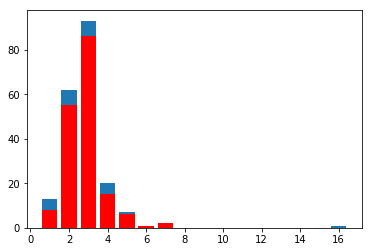

In [91]:
import numpy as np

set_lengths = [len(x) for x in sets_by_tune]
user_set_lengths = [len(x) for x in user_sets_by_tune]

import matplotlib.pyplot as plt
from collections import Counter

# Create your list
x = range(10)
x.append(1)

# Use a Counter to count the number of instances in x
c1 = Counter(set_lengths)
c2 = Counter(user_set_lengths)

keys = range(1,max(max(c1.keys()),max(c2.keys()))+1);

vals1 = np.zeros(len(keys)); vals2 = np.zeros(len(keys))

for k,v in zip(c1.keys(),c1.values()):
    vals1[k-1] = v
for k,v in zip(c2.keys(),c2.values()):
    vals2[k-1] = v

p1 = plt.bar(keys, vals1,color='red')
p2 = plt.bar(keys, vals2, bottom=vals1)

#plt.bar(c.keys(), c.values())
plt.show()

In [96]:
# This already works passing a tune_by_set from both user and recorded sets

def tunesBeforeAndAfter(tune_id, sets):
    
    tunes_before = []
    tunes_after = []
    position = []
    
    for aset in sets:
        #print aset
        before = None
        after = None
        for i,tune in enumerate(aset):
            #print tune
            if tune['tune_id'] == tune_id:
                if i > 0: # if not the first tune
                    before = aset[i-1]
                if i < len(aset)-1: # if not the last tune
                    after = aset[i+1]
                
                #break
        
        # classify the tune as first, middle, last or only
        if before is None and after is None:
            pos = 'only'
        elif before is None:
            pos = 'first'
        elif after is None:
            pos = 'last'
        else: 
            pos = 'middle'
                
        tunes_before.append(before)
        tunes_after.append(after)
        position.append(pos)
                    
    return tunes_before,tunes_after,position

def tunesInSetWith(tune_id, sets):
    
    tunes = []
    
    for aset in sets:
        #print aset
        for tune in aset:
            #print tune
            if tune['tune_id'] == tune_id:
                pass
            else:
                tunes.append(tune)
    return tunes
             
#tunesInSetWith(tune_id,sets_by_tune)

tunes_before,tunes_after,tune_pos = tunesBeforeAndAfter(tune_id,sets_by_tune+user_sets_by_tune)
print len(tunes_before), len(tunes_after), len(sets_by_tune)+len(user_sets_by_tune)
tunes_before[:5]

199 199 199


[{'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u'Happy Man, The',
  'rhythm': u'reel',
  'tune_id': u'2122'},
 {'meter': u'4/4',
  'mode': u'Dmajor',
  'name': u'Boyne Hunt, The',
  'rhythm': u'reel',
  'tune_id': u'142'},
 None,
 None,
 {'meter': u'4/4',
  'mode': u'Gmajor',
  'name': u"S'iomadh Rud A Chunnaic Mi",
  'rhythm': u'reel',
  'tune_id': u'5478'}]

In [94]:
print len(tunes_before), len(tunes_after), len(sets_by_tune)+

199 199 173


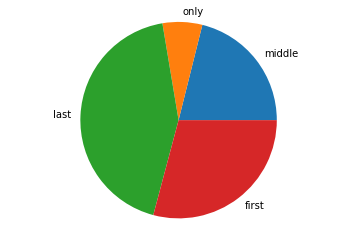

In [121]:
# Plot the distribution tune position

f,ax = plt.subplots(1,1)


keys = Counter(tune_pos).keys() # equals to list(set(words))
vals = Counter(tune_pos).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax.axis('equal')


plt.show()

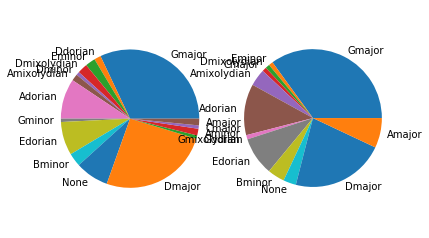

In [98]:
# Plot the distribution tune modes that are played with

f,(ax1,ax2) = plt.subplots(1,2)

data = []

for x in tunes_before:
    if x is not None:
        data.append(x['mode'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax1.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax1.axis('equal')

data = []

for x in tunes_after:
    if x is not None:
        data.append(x['mode'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax2.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax2.axis('equal')
plt.show()

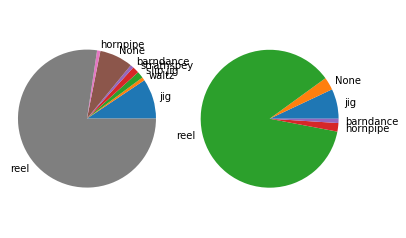

In [99]:
# Plot the distribution tune modes that are played with

f,(ax1,ax2) = plt.subplots(1,2)

data = []

for x in tunes_before:
    if x is not None:
        data.append(x['rhythm'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax1.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax1.axis('equal')

data = []

for x in tunes_after:
    if x is not None:
        data.append(x['rhythm'])

keys = Counter(data).keys() # equals to list(set(words))
vals = Counter(data).values() # counts the elements' frequency

# Data to plot
labels = keys
sizes = vals
#colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue']
#explode =   # explode 1st slice
 
# Plot
ax2.pie(sizes, labels=labels) #colors=colors,
        #autopct='%1.1f%%', shadow=True, startangle=140)
 
ax2.axis('equal')
plt.show()

In [100]:
def tunesMatchingParameters(tune_df,mode=None,rhythm=None,meter=None,tune_id_list=None):

    df = tune_df
    
    if not mode is None:
        #print mode
        if isinstance(mode, basestring):
            #print 'Constraining by mode'
            df = df[df['mode'] == mode]
        else:
            #print 'Constraining by mode in list'
            try:
                df = df[df['mode'].isin(mode)]
            except:
                pass
    
    if not rhythm is None:
        #print rhythm
        if isinstance(rhythm, basestring):
            #print 'Constraining by rhythm'
            df = df[df['rhythm'] == rhythm]
        else:
            #print 'Constraining by rhythm in list'
            try:
                df = df[df['rhythm'].isin(rhythm)]
            except:
                pass
    if not meter is None:
        #print rhythm
        if isinstance(meter, basestring):
            #print 'Constraining by meter'
            df = df[df['meter'] == meter]
        else:
            #print 'Constraining by meter in list'
            try:
                df = df[df['meter'].isin(meter)]
            except:
                pass
    
    try:
        df = df[df['tune_id'].isin(tune_id_list)]
    except:
        pass
            
    return df



In [101]:
import pandas as pd

def displayUniqueTuneInfo(tune_query,**kwargs): #mode=None,rhythm=None,meter=None,tune_list=None):
    tunes = []
    for x in tune_query:
        if x is not None:
            tunes.append(x)

    df = pd.DataFrame(tunes)
    
    df = tunesMatchingParameters(df,**kwargs)
    
    #print df

    gb = df.groupby('tune_id')['tune_id']
    #gan_ainm = {'tune_id':None,'name':u'Gan Ainm','rhythm':None,'meter':None,'mode':None}

    df = df.drop_duplicates()
    df.index = df.tune_id

    df = df.sort_index()

    s = gb.count()

    s.sort_index()
    df['count'] = s 

    df = df.sort_values('count',ascending=False)

    return df[['name','rhythm','mode','count']]

In [102]:
# print a list of tunes played before (by count)
displayUniqueTuneInfo(tunes_before,mode=['Adorian','Gmajor','Eminor'],meter='6/8')

,name,rhythm,mode,count
tune_id,,,,
14182,"Lark In The Morning, The",jig,Eminor,1
674,"Gravel Walks, The",jig,Adorian,1
728,Scatter The Mud,jig,Adorian,1


In [103]:
# print a list of tunes played after (by count)
displayUniqueTuneInfo(tunes_after,mode=['Amajor','Amixolydian'],rhythm='reel')

,name,rhythm,mode,count
tune_id,,,,
44,"High, The",reel,Amixolydian,2
74,"Mason's Apron, The",reel,Amajor,2
196,"Contradiction, The",reel,Amajor,1
361,"Kylebrack Rambler, The",reel,Amixolydian,1
566,"Jolly Beggerman, The",reel,Amixolydian,1
646,Frank's,reel,Amajor,1
729,Siobhan O'Donnell's,reel,Amajor,1
8171,"White Leaf, The",reel,Amajor,1
936,"Fair Wind, The",reel,Amajor,1


In [135]:
# We want to be able to look at the abc's from adjacent tunes. With the user sets we can do this directly


# For a given tune...sets may use different sets
set_entries = userSetEntryWithTune(182)

setting_ids = [x['setting_id'] for x in set_entries]
setting_count = Counter(setting_ids)

print setting_count

# might be useful to be able to constrain this by mode, etc...
def mostPopularSettingOfTune(tune_id):
    
    set_entries = userSetEntryWithTune(tune_id)
    
    # return none if tune has no sets
    if len(set_entries) == 0:
        return None
    
    setting_ids = [x['setting_id'] for x in set_entries]
    setting_count = Counter(setting_ids)
    
    return setting_count.keys()[0]

def defaultSettingOfTune(tune_id):
    
    popular = mostPopularSettingOfTune(tune_id)
    
    if popular is None:
        return settingsOfTune(tune_id)[0]['setting_id']
    
    return popular
           
print mostPopularSettingOfTune('182') 
print defaultSettingOfTune('182')  

# return tunes matching 'setting_id' instead of 'tune_id'
#userSetEntryWithTune(182,field='setting_id')[:5]
st,ss = userSetsWithTune(tune_id,field='setting_id')
ss[:2]

Counter({u'182': 19, u'12832': 4, u'20993': 2, u'12830': 1})
182
182


[[{'_id': 4162,
   'abc': u'A|:FA (3AAA BAFA|dfed BddA|FA (3AAA BAFA|dfed (3BdB AG|\r\n|FA (3AAA BAFA|dfed Bdef|gage fgfe|1 dfed (3BdB AG:|2 dfed BdAd||\r\n|:fa (3aaa bfaf|gfed Bdde|fa (3aaa bfaf|gfed (3BdB A2|\r\n|fa (3aaa bfaf|gfed Bdef|~g3 e ~f3 e|1 dfed BdAd:|2 dfed B2 AG||',
   'date': u'2016-06-05 20:58:06',
   'meter': u'4/4',
   'mode': u'Dmajor',
   'name': u'Silver Spear, The',
   'num_tunes': 1,
   'rhythm': u'reel',
   'set_id': u'2275',
   'setting_id': u'182',
   'tune_id': u'182',
   'tune_position': 1,
   'user': u'104250',
   'username': u'Bernie Kelly '}],
 [{'_id': 45,
   'abc': u'A|:FA (3AAA BAFA|dfed BddA|FA (3AAA BAFA|dfed (3BdB AG|\r\n|FA (3AAA BAFA|dfed Bdef|gage fgfe|1 dfed (3BdB AG:|2 dfed BdAd||\r\n|:fa (3aaa bfaf|gfed Bdde|fa (3aaa bfaf|gfed (3BdB A2|\r\n|fa (3aaa bfaf|gfed Bdef|~g3 e ~f3 e|1 dfed BdAd:|2 dfed B2 AG||',
   'date': u'2016-02-06 19:59:19',
   'meter': u'4/4',
   'mode': u'Dmajor',
   'name': u'Silver Spear, The',
   'num_tunes': 2,
   'rhythm'

In [154]:
def settingPairsUser(setting_id):
    # Get pairs of settings for tunes preceeding and for the exact setting_id
    
    field = 'setting_id' # always use setting_id
    st,ss = userSetsWithTune(setting_id,field,json=True)
    
    settings_before = []
    settings_after = []
    position = []
    
    for aset in ss:
        #print aset
        before = None
        after = None
        for i,setting in enumerate(aset):
            #print tune
            if setting[field] == setting_id:
                if i > 0: # if not the first tune
                    before = aset[i-1]
                if i < len(aset)-1: # if not the last tune
                    after = aset[i+1]
                
                break
        
        # classify the tune as first, middle, last or only
        if before is None and after is None:
            pos = 'only'
        elif before is None:
            pos = 'first'
        elif after is None:
            pos = 'last'
        else: 
            pos = 'middle'
                
        settings_before.append(before)
        settings_after.append(after)
        position.append(pos)
        
    sid_before = []
    sid_after = []
        
    for s in settings_before:
        try:
            sid = s['setting_id']
            sid_before.append((sid,setting_id))
            
        except:
            pass
        
    for s in settings_after:
        try:
            sid = s['setting_id']
            sid_after.append((setting_id,sid))
            
        except:
            pass
                    
    return sid_before,sid_after

sb,sa = settingPairsUser('182')

print sa

[('182', u'629'), ('182', u'629'), ('182', u'13932'), ('182', u'98'), ('182', u'566'), ('182', u'116'), ('182', u'1'), ('182', u'197'), ('182', u'399'), ('182', u'791')]


In [161]:
def settingPairsRecordingsDefault(tune_id):
    # get pairs of tune settings using the default
    
    setting_id = defaultSettingOfTune(tune_id)
    
    field = 'tune_id' # always use setting_id
    
    sets,sr = recordedSetsWithTune(setting_id,field)
    
    tb,ta,p = tunesBeforeAndAfter(tune_id, sets)
    
    sid_before = []
    sid_after = []
    for t in tb:
        try:
            sid = defaultSettingOfTune(t['tune_id'])
            sid_before.append((sid,setting_id))
        except:
            pass
        
    for t in ta:
        try:
            sid = defaultSettingOfTune(t['tune_id'])
            sid_after.append((setting_id,sid))
        except:
            pass
    
    return sid_before,sid_after
        
sb,sa = settingPairsRecordingsDefault('182')
sa

[(u'182', u'7092'),
 (u'182', u'129'),
 (u'182', u'24515'),
 (u'182', u'14449'),
 (u'182', u'1554'),
 (u'182', u'511'),
 (u'182', u'3741'),
 (u'182', u'13269'),
 (u'182', u'13269'),
 (u'182', u'1174'),
 (u'182', u'756'),
 (u'182', u'346'),
 (u'182', u'471'),
 (u'182', u'13520'),
 (u'182', u'13520'),
 (u'182', u'584'),
 (u'182', u'23357'),
 (u'182', u'13934'),
 (u'182', u'13162'),
 (u'182', u'543'),
 (u'182', u'20688'),
 (u'182', u'24515'),
 (u'182', u'729'),
 (u'182', u'24524'),
 (u'182', u'12648'),
 (u'182', u'15942'),
 (u'182', u'13269'),
 (u'182', u'2429'),
 (u'182', u'44'),
 (u'182', u'12408'),
 (u'182', u'605'),
 (u'182', u'13948'),
 (u'182', u'7222'),
 (u'182', u'8171'),
 (u'182', u'16339'),
 (u'182', u'517'),
 (u'182', u'2689'),
 (u'182', u'75'),
 (u'182', u'13269'),
 (u'182', u'13134'),
 (u'182', u'196'),
 (u'182', u'13269'),
 (u'182', u'98'),
 (u'182', u'12904'),
 (u'182', u'32119'),
 (u'182', u'936'),
 (u'182', u'1348'),
 (u'182', u'573'),
 (u'182', u'1174'),
 (u'182', u'98')

[(u'182', u'7092'),
 (u'182', u'129'),
 (u'182', u'24515'),
 (u'182', u'14449'),
 (u'182', u'1554'),
 (u'182', u'511'),
 (u'182', u'3741'),
 (u'182', u'13269'),
 (u'182', u'13269'),
 (u'182', u'1174'),
 (u'182', u'756'),
 (u'182', u'346'),
 (u'182', u'471'),
 (u'182', u'13520'),
 (u'182', u'13520'),
 (u'182', u'584'),
 (u'182', u'23357'),
 (u'182', u'13934'),
 (u'182', u'13162'),
 (u'182', u'543'),
 (u'182', u'20688'),
 (u'182', u'24515'),
 (u'182', u'729'),
 (u'182', u'24524'),
 (u'182', u'12648'),
 (u'182', u'15942'),
 (u'182', u'13269'),
 (u'182', u'2429'),
 (u'182', u'44'),
 (u'182', u'12408'),
 (u'182', u'605'),
 (u'182', u'13948'),
 (u'182', u'7222'),
 (u'182', u'8171'),
 (u'182', u'16339'),
 (u'182', u'517'),
 (u'182', u'2689'),
 (u'182', u'75'),
 (u'182', u'13269'),
 (u'182', u'13134'),
 (u'182', u'196'),
 (u'182', u'13269'),
 (u'182', u'98'),
 (u'182', u'12904'),
 (u'182', u'32119'),
 (u'182', u'936'),
 (u'182', u'1348'),
 (u'182', u'573'),
 (u'182', u'1174'),
 (u'182', u'98')

In [3]:
#import pyabc
from pyabc import *
import json
import numpy as np

import os
import sqlite3  # this is the module that binds to SQLite
import pandas as pd  # you'll see why we can use this later

#from progress import progress

https://thesession.org/api

Formats
JSON	?format=json
XML	?format=xml
RSS	?format=rss
Endpoints
The following lists are available in multiple formats e.g. /tunes/new?format=json or /recordings/search?q=altan&format=rss

By default, 10 items will be returned in a list. You can request up to 50 items by appending &perpage= e.g. /tunes/new?format=json&perpage=35

If you request an individual item, e.g. /tunes/27?format=xml, you will get back the details for that item and any comments that have been posted to it.

In [ ]:
# setup database

DBFILE = 'thesession.db'  # this will be our database
BASEDIR = os.getcwd() + '/sqlite3'  # os.path.abspath(os.path.dirname(__file__))
DBPATH = os.path.join(BASEDIR, DBFILE)

# we may need to delete the existing file first
if os.path.exists(DBPATH):
    os.remove(DBPATH)

# open a connection to the database for this tutorial
conn = sqlite3.connect(DBPATH)

# get a cursor to the database
cur = conn.cursor()

In [ ]:
def get_thesession_jsons():
    import os, json
    #if not os.path.isfile("tunes.json"):
    import sys, urllib
    for f in ['tunes','recodings','aliases','events','sessions']:
        url = 'https://raw.githubusercontent.com/adactio/TheSession-data/master/json/'+f+'.json'
        print("Downloading "+f+" database from %s..." % url)
        try:
            urllib.urlretrieve(url, 'json/'+f+'.json')
        except AttributeError:
            import urllib.request
            urllib.request.urlretrieve(url, 'json/'+f+'.json')
    #return json.loads(open('tunes.json', 'rb').read().decode('utf8'))
    
#get_thesession_jsons()

In [4]:
json_tunes = json.loads(open('json/tunes.json', 'rb').read().decode('utf8'))
json_recordings = json.loads(open('json/recordings.json', 'rb').read().decode('utf8'))
json_aliases = json.loads(open('json/aliases.json', 'rb').read().decode('utf8'))
json_events = json.loads(open('json/events.json', 'rb').read().decode('utf8'))
json_sessions = json.loads(open('json/sessions.json', 'rb').read().decode('utf8'))
json_sets = json.loads(open('json/sets.json', 'rb').read().decode('utf8'))

In [5]:
json_sets[18]

{u'abc': u'|:BGG DGG|BGB dcB|cAA EAA|cAc edc|\rBGG DGG|BGB dcB|cBc Adc|BGG G3:|\r|:BGG DGG|BGB BAG|AFF DFF|AFA AGF|\rEGG DGG|CGG B,GG|cBc Adc|BGG G3:|',
 u'date': u'2016-02-06 19:17:37',
 u'member_id': u'87410',
 u'meter': u'6/8',
 u'mode': u'Gmajor',
 u'name': u'Irish Washerwoman, The',
 u'setting_id': u'92',
 u'settingorder': u'3',
 u'tune_id': u'92',
 u'tuneset': u'17',
 u'type': u'jig',
 u'username': u'Alexander Gurgan'}

In [7]:
# unicode
print json_sets[100].keys()

[u'username', u'settingorder', u'abc', u'tuneset', u'tune_id', u'setting_id', u'mode', u'meter', u'member_id', u'date', u'type', u'name']


In [ ]:
n_test = 10

In [ ]:
json_tunes[41]

In [ ]:
# From tunes.json

# users 
try:
    cur.execute('DROP TABLE users')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE users (
    user TEXT PRIMARY KEY
)''')
conn.commit()

# tunes
try:
    cur.execute('DROP TABLE tunes')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE tunes (
    tune_id TEXT PRIMARY KEY,
    name TEXT NOT NULL,
    rhythm TEXT NOT NULL,
    meter TEXT NOT NULL,
    mode TEXT NOT NULL
)''')
conn.commit()

# settings
try:
    cur.execute('DROP TABLE settings')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE settings (
    setting_id TEXT PRIMARY KEY,
    tune_id TEXT NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE,
    abc  TEXT,
    date TEXT NOT NULL,
    user TEXT NOT NULL REFERENCES users on UPDATE CASCADE ON DELETE CASCADE,
    name TEXT NOT NULL,
    rhythm TEXT NOT NULL,
    meter TEXT NOT NULL,
    mode TEXT NOT NULL,
    bars INTEGER,
    structure TEXT
)''')
conn.commit()

In [ ]:
# Insert entries from tunes.json
N = 1000
for i,jj in enumerate(json_tunes[:N]): 
    
    # Fill missing with None
    keys = ['setting','tune','abc','date','username','name','type','meter','mode']
    j = {}   
    for x in keys:
        try:
            j.update({x:jj[x]})
        except:
            j.update({x:None})
    
    # Check if user is new, if so add to table
    cur.execute('SELECT * FROM users WHERE (user=?)', [j['username']])
    entry = cur.fetchone()
    if entry is None:
        cur.execute('INSERT INTO users VALUES (?)', [j['username']])
        
    # Check if tune is new, if so add to table
    cur.execute('SELECT * FROM tunes WHERE (tune_id=?)', [j['tune']])
    entry = cur.fetchone()
    if entry is None:
        row = [j['tune'],j['name'],j['type'],j['meter'],j['mode']]
        cur.execute('INSERT INTO tunes VALUES (?,?,?,?,?)', row)

    row = [j['setting'],j['tune'],j['abc'],j['date'],j['username'],j['name'],j['type'],j['meter'],j['mode']]
    cur.execute('INSERT INTO settings VALUES (?,?,?,?,?,?,?,?,?,NULL,NULL)',row)
    progress(i+1,N,'Transfering tune settings from JSON to SQL.')
    
conn.commit()  # you must commit for it to become permanent


In [ ]:
cur.execute('SELECT * FROM users')
cur.fetchall()  # fetch all the results of the query

In [ ]:
cur.execute('SELECT * FROM tunes')
cur.fetchall()  # fetch all the results of the query

In [ ]:
cur.execute('SELECT setting_id, tune_id, date, user FROM settings')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from aliases.json

# Create aliases table
try:
    cur.execute('DROP TABLE aliases')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE aliases (
    alias_id INTEGER PRIMARY KEY,
    alias TEXT NOT NULL,
    name TEXT NOT NULL,
    tune_id NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE
)''')
conn.commit()

In [ ]:
# insert entries from aliases.json
N = 1000
cur.execute('SELECT MAX(alias_id) from aliases')
try:
    startid = int(cur.fetchone()[0])+1
except:
    startid = 0
        
for i,j in enumerate(json_aliases[:N]):
    keys = ['alias','name','tune_id']
    jj = {}   
    for x in keys:
        try:
            jj.update({x:j[x]})
        except:
            jj.update({x:None})
    
    row = [startid+i,jj['alias'],jj['name'],jj['tune_id']]
    cur.execute('INSERT INTO aliases VALUES (?,?,?,?)',row)
    progress(i+1,N,'Transferrring aliases from JSON to SQL.')
conn.commit()

In [ ]:
cur.execute('SELECT MAX(alias_id) from aliases')
startid = int(cur.fetchone()[0])+1
startid

In [ ]:
cur.execute('SELECT * FROM aliases')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from recordings.json

#artists
try:
    cur.execute('DROP TABLE artists')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE artists (
    artist TEXT PRIMARY KEY
)''')
conn.commit()

# recordings  (albums)
try:
    cur.execute('DROP TABLE recordings')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE recordings (
    recording_id TEXT PRIMARY KEY,
    recording_name TEXT NOT NULL,
    artist TEXT REFERENCES artists ON UPDATE CASCADE ON DELETE CASCADE
)''')
conn.commit()

# recorded tunes
try:
    cur.execute('DROP TABLE recorded_tunes')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE recorded_tunes (
    id TEXT PRIMARY KEY,
    recording_id TEXT REFERENCES recordings ON UPDATE CASCADE ON DELETE CASCADE,
    recording_name TEXT NOT NULL,
    artist TEXT REFERENCES artists ON UPDATE CASCADE ON DELETE CASCADE,
    track INTEGER NOT NULL,
    number INTEGER NOT NULL,
    tune_name TEXT, 
    tune_id NOT NULL REFERENCES tunes ON UPDATE CASCADE ON DELETE CASCADE
    
)''')
conn.commit()

In [ ]:
# Insert entries from recordings.json
N = 1000
for i,j in enumerate(json_recordings[:N]): 
    
    keys = ['id','recording','artist','track','number','tune','tune_id']
    jj = {}   
    for x in keys:
        try:
            jj.update({x:j[x]})
        except:
            jj.update({x:None})
    
    # Check if user is new, if so add to table
    cur.execute('SELECT * FROM artists WHERE (artist=?)', [jj['artist']])
    entry = cur.fetchone()
    if entry is None:
        cur.execute('INSERT INTO artists VALUES (?)', [jj['artist']])
        
    # Check if tune is new, if so add to table
    cur.execute('SELECT * FROM recordings WHERE (recording_id=?)', [jj['id']])
    entry = cur.fetchone()
    if entry is None:
        row = [j['id'],j['recording'],j['artist']]
        cur.execute('INSERT INTO recordings VALUES (?,?,?)', row)

    row = [i,jj['id'],jj['recording'],jj['artist'],int(jj['track']),int(jj['number']),jj['tune'],jj['tune_id']]
    cur.execute('INSERT INTO recorded_tunes VALUES (?,?,?,?,?,?,?,?)',row)
    progress(i+1,N,'Transferring recordings from JSON to SQL.')
    
conn.commit()  # you must commit for it to become permanent
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky

In [ ]:
cur.execute('SELECT * FROM recordings')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from events.json
try:
    cur.execute('DROP TABLE events')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE events (
    event_id TEXT PRIMARY KEY,
    address TEXT,
    area TEXT,
    country TEXT,
    dtend TEXT,
    dtstart TEXT,
    event_name TEXT,
    latitude TEXT,
    logitude TEXT,
    town TEXT,
    venue TEXT
)''')
conn.commit()

In [ ]:
progress?

In [ ]:
N = 1000
for i,j in enumerate(json_events[:N]):    

    keys = ['id','address','area','country','dtend','dtstart','event','latitude','longitude','town','venue']
    row = [ None for x in range(len(keys))]
    
    for x in  range(len(keys)):
        try:
            row[x] = j[keys[x]]
        except:
            pass
    #row = [j['id'],j['address'],j['area'],j['country'],j['dtend'],j['dtstart'],j['event'],
    #      j['latitude'],j['longitude'],j['town'],j['venue']]
    cur.execute('INSERT INTO events VALUES (?,?,?,?,?,?,?,?,?,?,?)',row)
    conn.commit()  # you must commit for it to become permanent
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky
    progress(i+1,N,'Transfering events from JSON to SQL.')

In [ ]:
cur.execute('SELECT * FROM events')
cur.fetchall()  # fetch all the results of the query

In [ ]:
# from sessions.json
try:
    cur.execute('DROP TABLE sessions')
    #conn.commit()
except:
    pass

cur.execute('''CREATE TABLE sessions (
    session_id TEXT PRIMARY KEY,
    address TEXT,
    area TEXT,
    country TEXT,
    date TEXT,
    latitude TEXT,
    logitude TEXT,
    name TEXT,
    town TEXT
)''')
conn.commit()

In [ ]:
json_sessions[1000]

In [ ]:
N = 1000
for i,j in enumerate(json_sessions[:N]):    

    keys = ['id','address','area','country','date','latitude','longitude','name','town']
    row = [ None for x in range(len(keys))]
    
    for x in  range(len(keys)):
        try:
            row[x] = j[keys[x]]
        except:
            pass
       
    #row = [j['id'],j['address'],j['area'],j['country'],j['date'],
    #      j['latitude'],j['longitude'],j['name'],j['town']]
    
    cur.execute('INSERT INTO sessions VALUES (?,?,?,?,?,?,?,?,?)',row)
    #cur.rowcount  # tells you how many rows written, sometimes, it's quirky
    progress(i+1,N,'Transfering sessions from JSON to SQL.')
conn.commit()  # you must commit for it to become permanent

In [ ]:
cur.execute('SELECT * FROM sessions')
cur.fetchall()  # fetch all the results of the query